In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import json
import yaml
from tqdm import tqdm
from Model.model import Mask_SAM
import cv2
import torch
from einops import repeat

In [57]:
traintxt = []
with open('../kvasir-instrument/train.txt', 'r') as file:
    for line in file:
        traintxt.append(line.strip())

In [58]:
len(traintxt)

472

In [59]:
testtxt = []
with open('../kvasir-instrument/test.txt', 'r') as file:
    for line in file:
        testtxt.append(line.strip())

In [60]:
len(testtxt)

118

In [50]:
images = os.listdir('../kvasir-instrument/images')

In [51]:
masks = os.listdir('../kvasir-instrument/masks')

In [ ]:

data_config_p= 'data_config.yml' 
model_config_p= 'model_config.yml' 
with open(data_config_p, 'r') as f:
        data_config_p = yaml.load(f, Loader=yaml.FullLoader)
with open(model_config_p, 'r') as f:
    model_config = yaml.load(f, Loader=yaml.FullLoader)
model_config['img_size'] = 256
model = Mask_SAM(model_config, "cuda:0")

In [ ]:
def extract_features(model, impath):
    img = Image.open('../kvasir-instrument/images/' + impath + '.jpg')
    img = np.array(img.convert('RGB'))
    img = cv2.resize(img, (model.img_size, model.img_size), interpolation=cv2.INTER_CUBIC)
    img = (img / 255.0).astype(np.float32)
    img = torch.as_tensor(img).permute(2,0,1)
    if img.dim() == 2: # for gray image
        img = img.unsqueeze(0)
        img = repeat(img, 'c h w -> (repeat c) h w', repeat=3)
    with torch.no_grad():
        img_embeddings = model.sam.image_encoder(img.unsqueeze(0).to(model.device)).detach().cpu().numpy()
    return img_embeddings
def GetImageFeatures(Train_Cache,model):
    features = []
    for impath in tqdm(Train_Cache):
        features.append(extract_features(model,impath)[0])
    return np.array(features)
def ComputeMostDifference(features):
    sum_of_loss = []
    for i in tqdm(range(features.shape[0])):
        s = 0
        for j in range(features.shape[0]):
            if i == j:
                continue
            else:
                s += np.mean((features[i] - features[j]) ** 2) 
        sum_of_loss.append(s)
    return np.array(sum_of_loss)

In [ ]:
print("GetFeatures...")
Features = GetImageFeatures(traintxt,model)
print("ComputeMostDifference...")
Diff = ComputeMostDifference(Features)
print("CollectData...")
sorted_indices = np.argsort(-Diff)
np.savez("/home/kappa7077/kvasir-instrument/Priority.npz",indices=sorted_indices)

In [ ]:
sorted_indices = np.load("/home/kappa7077/kvasir-instrument/Priority.npz")['indices']
sorted_indices

In [83]:
from PIL import Image
import numpy as np

grid = {}
output = []
def process_image(impath, idx):
    # Step 1: Open the image and convert to grayscale
    image = Image.open('../kvasir-instrument/masks/' + impath +'.png' ).convert('L')

    # Step 2: Resize the image to (255, 255) and convert to NumPy array
    image = image.resize((255, 255))
    image_array = np.array(image)>0+0

    # Step 3: Divide the image into 4x4 regions and compute grid
    image_range = set()
    for i in range(5):
        for j in range(5):
            region = image_array[i*51:(i+1)*51, j*51:(j+1)*51]
            if np.any(region == 1):
                image_range.add(i*4+j)
    
    if all(grid.get(ir, 0) >= 14 for ir in image_range): 
        pass
    else:
        output.append(idx)
        for ir in image_range:
            grid[ir] = grid.get(ir, 0) + 1
#     print(image_range)
#     print(grid)

for idx in sorted_indices:
    process_image(traintxt[idx], idx)
print(grid)
print(len(output))


{6: 30, 7: 19, 10: 39, 11: 28, 12: 19, 15: 37, 16: 18, 19: 32, 20: 20, 14: 42, 18: 26, 1: 22, 2: 20, 3: 14, 8: 21, 9: 26, 13: 21, 17: 14, 0: 14, 4: 24, 5: 23}
69


In [85]:
np.savez("../kvasir-instrument/cache_list.npz",cache=output)

(616, 531)
(572, 530)
(624, 532)
(572, 532)
(633, 532)
(633, 532)
(596, 529)
(628, 530)
(633, 531)
(623, 532)
(627, 548)
(623, 532)
(633, 532)
(623, 532)
(623, 530)
(623, 530)
(622, 530)
(623, 531)
(614, 529)
(572, 532)
(572, 532)
(1210, 1011)
(1225, 1013)
(571, 532)
(571, 532)
(768, 576)
(1920, 1072)
(768, 576)
(1920, 1072)
(1225, 1015)
(720, 576)
(1280, 1024)
(1280, 1024)
(1920, 1072)
(768, 576)
(618, 532)
(1280, 1024)
(1349, 1071)
(1280, 1024)
(1280, 1024)
(1920, 1072)
(720, 576)
(768, 576)
(1280, 1024)
(1280, 1024)
(720, 576)
(1280, 1024)
(720, 576)
(1280, 1024)
(768, 576)
(1280, 1024)
(1280, 1024)
(1280, 1024)
(1280, 1024)
(1280, 1024)
(768, 576)
(1280, 1024)
(1280, 1024)
(768, 576)
(768, 576)
(1280, 1024)
(1280, 1024)
(768, 576)
(1280, 1024)
(768, 576)
(1280, 1024)
(1280, 1024)
(1280, 1024)
(1280, 1024)


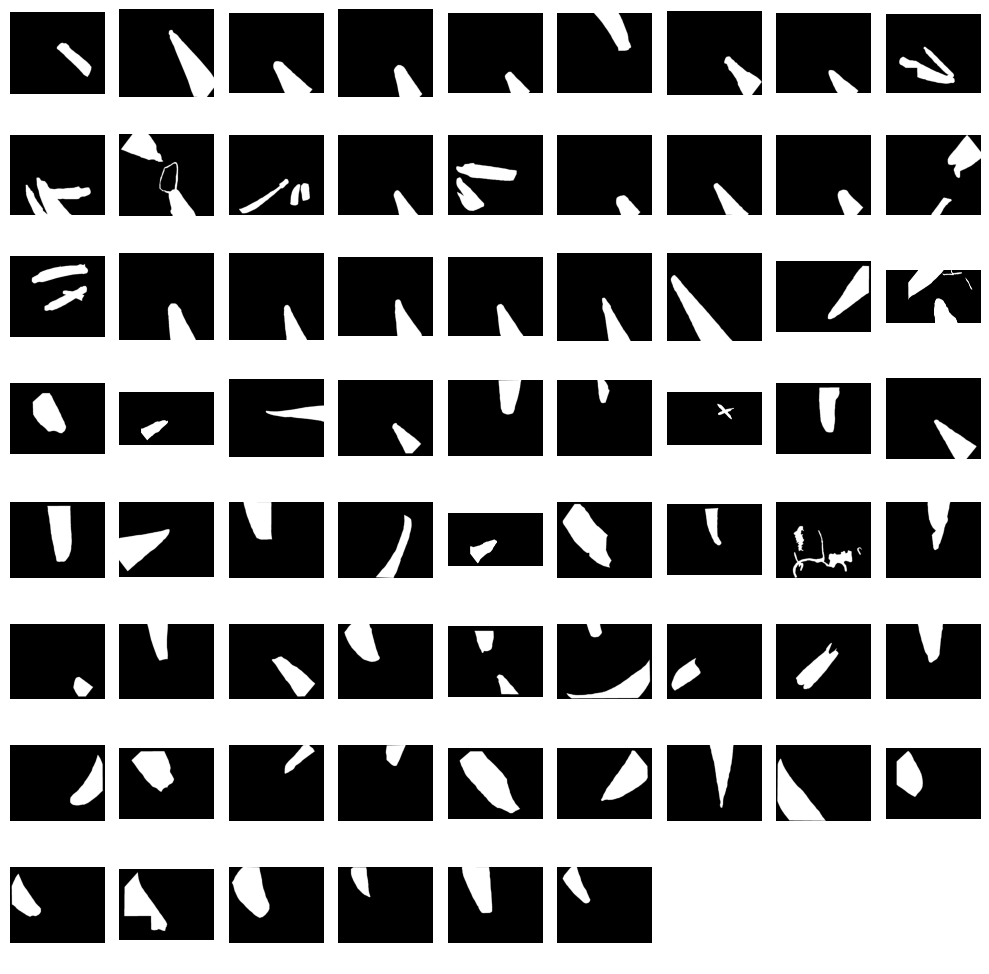

In [93]:
from PIL import Image
import matplotlib.pyplot as plt
import math

# 打開10張PNG圖像
image_paths = []
for idx in output:
    image_paths.append(traintxt[idx])

images = [Image.open('../kvasir-instrument/masks/' + path + '.png') for path in image_paths]

# 計算所需的行數和列數
num_images = len(images)
rows = 8
cols = math.ceil(num_images / rows)

# 創建一個新的大圖像來排列圖像
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

# 將每個圖像添加到對應的軸上
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        print(images[i].size)
        ax.axis('off')
    else:
        ax.axis('off')  # 隱藏多餘的軸

plt.tight_layout()  # 自動調整子圖間的間距
plt.show()

In [87]:
train_cache = []
train_data = []
for i,train_name in enumerate(traintxt):   
    cache = []
    data = []
    
    cache.append('images/'+ train_name + '.jpg')
    cache.append({'0':'masks/' + train_name + '.png'})
    cache.append('')
    cache.append(i)

    data.append('images/'+ train_name + '.jpg')
    data.append(0)
    data.append('masks/' + train_name + '.png')
    data.append(i)

    train_cache.append(cache)
    train_data.append(data)

In [88]:
train_data[0:5]

[['images/ckcvw5yhd000m3b5yutirmiad.jpg',
  0,
  'masks/ckcvw5yhd000m3b5yutirmiad.png',
  0],
 ['images/ckcvwpanj001b3b5ysxixpcxy.jpg',
  0,
  'masks/ckcvwpanj001b3b5ysxixpcxy.png',
  1],
 ['images/ckcuhbkeo000z3b5yq7v1sm0o.jpg',
  0,
  'masks/ckcuhbkeo000z3b5yq7v1sm0o.png',
  2],
 ['images/ckd0afl7u000a3b5y3crqjxla.jpg',
  0,
  'masks/ckd0afl7u000a3b5y3crqjxla.png',
  3],
 ['images/ckcxb6cne000x3b5ynaznq58f.jpg',
  0,
  'masks/ckcxb6cne000x3b5ynaznq58f.png',
  4]]

In [89]:
test_cache = []
test_data = []
for i,test_name in enumerate(testtxt):   
    cache = []
    data = []
    
    cache.append('images/'+ test_name + '.jpg')
    cache.append({'0':'masks/' + test_name + '.png'})
    cache.append('')
    cache.append(0)


    data.append('images/'+ test_name + '.jpg')
    data.append(0)
    data.append('masks/' + test_name + '.png')
    data.append(0)

    test_cache.append(cache)
    test_data.append(data)

In [90]:
test_data[:5]

[['images/ckd4ipizn000d3b5yk2vrbyyz.jpg',
  0,
  'masks/ckd4ipizn000d3b5yk2vrbyyz.png',
  0],
 ['images/ckcxct8oj000k3b5y9iwia72h.jpg',
  0,
  'masks/ckcxct8oj000k3b5y9iwia72h.png',
  0],
 ['images/ckd4ig3d700043b5y0p70afjj.jpg',
  0,
  'masks/ckd4ig3d700043b5y0p70afjj.png',
  0],
 ['images/ckd03in4g001d3b5yngyc734r.jpg',
  0,
  'masks/ckd03in4g001d3b5yngyc734r.png',
  0],
 ['images/ckcx9nmko001u3b5yopeccdvo.jpg',
  0,
  'masks/ckcx9nmko001u3b5yopeccdvo.png',
  0]]

In [ ]:
mask = np.load('masks/ckd03in4g001d3b5yngyc734r.npz')['image']
plt.imshow(mask)

In [41]:
len(test_data)

3068

In [91]:
cache = {
    'train': train_cache,
    'test': test_cache,
    'val' : ''
}
data = {
    'train': train_data,
    'test': test_data,
    'val' : ''
}

In [92]:
with open('../kvasir-instrument/cache.json', 'w') as file:
    json.dump(cache, file, indent=4)
with open('../kvasir-instrument/data.json', 'w') as file:
    json.dump(data, file, indent=4)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=3, gamma=3, loss_weight=None, reduction='mean', **kwargs):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smooth = 1e-6
        self.loss_weight = loss_weight
        self.reduction = reduction

        assert self.reduction in ['none', 'mean', 'sum']

    def forward(self, output, target, labels, label_weight):
        prob = torch.sigmoid(output)
        prob = torch.clamp(prob, self.smooth, 1.0 - self.smooth)
        weight_for_loss = label_weight[labels]
        print(weight_for_loss)
        pos_mask = (target == 1).float()
        neg_mask = (target == 0).float()

        pos_weight = (pos_mask * torch.pow(1 - prob, self.gamma)).detach()
        pos_loss = -pos_weight * torch.log(prob)

        neg_weight = (neg_mask * torch.pow(prob, self.gamma)).detach()
        neg_loss = -self.alpha * neg_weight * F.logsigmoid(-output)
        
        # Weighted sum of positive and negative losses using labels and loss_weight
        pos_loss_weighted = torch.sum(pos_loss * weight_for_loss , dim=0)
        neg_loss_weighted = torch.sum(neg_loss * weight_for_loss , dim=0)
        print(pos_loss)
        print(pos_loss_weighted)
        print(neg_loss)
        print(neg_loss_weighted)
        loss = pos_loss_weighted + neg_loss_weighted

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()

        return loss

# Example usage:
loss_function = BinaryFocalLoss()

output = torch.randn(5, 1)  # Example output tensor, shape: (batch_size, 1)
target = torch.randint(0, 2, (5, 1))  # Example target tensor, shape: (batch_size, 1)
labels = torch.randint(0, 3,(5, 1))  # Example label tensor, shape: (batch_size, 1)
print(labels)
loss_weight = torch.randn(3, 1)  # Example loss_weight tensor, shape: (batch_size, 1)
print(f'loss weight\n:{loss_weight}')
loss = loss_function(output, target, labels, loss_weight)
print(loss)

In [ ]:
labels = torch.randint(0, 3,(5, 1)) 
label_weight = torch.randn(3, 1)
print(labels)
print(label_weight)

In [ ]:
import torch

# 你的 labels 和 label_weight
labels = torch.randint(0, 3, (5, 1))
label_weight = torch.randn(3, 1)

# 使用 gather 函數選取對應的權重
weight_for_loss = label_weight.gather(0, labels)

# 現在你可以使用 weight_for_loss 與你的 loss 做 element-wise 的相乘
# 假設你的 loss 是一個與 weight_for_loss 形狀相同的 tensor
loss = torch.randn(5, 1)
weighted_loss = loss * weight_for_loss

In [ ]:
print(labels)
print(label_weight)
print(weight_for_loss)
print(loss)
print(weighted_loss)